In [1]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Display settings
pd.set_option('display.max_columns', None)

# Load dataset
df = pd.read_excel("materials_database_600.xlsx")

# Basic cleaning
df = df.dropna()

# Encode categorical variables
le = LabelEncoder()
df['Category'] = le.fit_transform(df['Category'])
df['Biodegradable'] = df['Biodegradable'].map({'Yes': 1, 'No': 0})

# Feature engineering
df['CO2_Impact_Index'] = df['CO2_Emission_kg'] / df['Density_kg_m3']
df['Cost_Efficiency_Index'] = df['Tensile_Strength_MPa'] / df['Cost_per_kg']
df['Material_Suitability_Score'] = (
    df['Biodegradable'] * 2 + df['Cost_Efficiency_Index'] - df['CO2_Impact_Index']
)

# Features and targets
features = ['Density_kg_m3', 'Tensile_Strength_MPa', 'Category', 'Biodegradable']
X = df[features]
y_cost = df['Cost_per_kg']
y_co2 = df['CO2_Emission_kg']

# Train-test split
X_train, X_test, y_cost_train, y_cost_test = train_test_split(
    X, y_cost, test_size=0.2, random_state=42
)
_, _, y_co2_train, y_co2_test = train_test_split(
    X, y_co2, test_size=0.2, random_state=42
)

print("Data ready. Rows:", len(df))
df.head()


Data ready. Rows: 600


,Material_ID,Material_Name,Category,Density_kg_m3,Tensile_Strength_MPa,CO2_Emission_kg,Cost_per_kg,Biodegradable,CO2_Impact_Index,Cost_Efficiency_Index,Material_Suitability_Score
0,1,Recycled Palm Leaf,0,489,13.19,0.235,1.06,1,0.000481,12.443396,14.442916
1,2,Waterproof Palm Leaf,0,561,15.29,0.449,1.47,1,0.000800,10.401361,12.400560
2,3,Single-Ply Kraft Paper,3,742,36.08,0.742,0.91,1,0.001000,39.648352,41.647352
3,4,Single-Ply Aluminum Foil,2,2506,32.48,11.137,3.30,0,0.004444,9.842424,9.837980
4,5,Fire-Retardant Nylon Fabric,4,1323,69.04,6.800,4.71,0,0.005140,14.658174,14.653034


In [2]:
# Random Forest for Cost prediction
rf = RandomForestRegressor(random_state=42)
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring='r2', n_jobs=-1, verbose=0)
rf_grid.fit(X_train, y_cost_train)
best_rf = rf_grid.best_estimator_

# XGBoost for CO2 prediction
xgb = XGBRegressor(random_state=42, verbosity=0)
xgb_params = {
    'n_estimators': [200, 400],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_grid = GridSearchCV(xgb, xgb_params, cv=3, scoring='r2', n_jobs=-1, verbose=0)
xgb_grid.fit(X_train, y_co2_train)
best_xgb = xgb_grid.best_estimator_

print("Best RF params:", rf_grid.best_params_)
print("Best XGB params:", xgb_grid.best_params_)


Best RF params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best XGB params: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


In [3]:
def evaluate(y_true, y_pred, label):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return pd.Series({'Model': label, 'RMSE': rmse, 'MAE': mae, 'R2': r2})

# Predictions on test sets
y_cost_pred = best_rf.predict(X_test)
y_co2_pred = best_xgb.predict(X_test)

results = pd.concat([
    evaluate(y_cost_test, y_cost_pred, "Cost Prediction (RandomForest)"),
    evaluate(y_co2_test, y_co2_pred, "CO2 Prediction (XGBoost)")
], axis=1).T

results


,Model,RMSE,MAE,R2
0,Cost Prediction (RandomForest),1.518805,0.876624,0.449483
1,CO2 Prediction (XGBoost),0.962744,0.47163,0.848573


In [4]:
# Predict on full dataset
df['Predicted_Cost'] = best_rf.predict(X)
df['Predicted_CO2'] = best_xgb.predict(X)

# Final ranking score: lower cost & CO2, higher suitability
df['Final_Rank_Score'] = (
    -df['Predicted_Cost'] - df['Predicted_CO2'] + df['Material_Suitability_Score']
)

recommendations = df.sort_values(by='Final_Rank_Score', ascending=False)

# Top-10 materials
top10 = recommendations[['Material_Name', 'Category', 'Biodegradable',
                         'Predicted_Cost', 'Predicted_CO2',
                         'Material_Suitability_Score', 'Final_Rank_Score']].head(10)
top10


,Material_Name,Category,Biodegradable,Predicted_Cost,Predicted_CO2,Material_Suitability_Score,Final_Rank_Score
374,Reinforced Steel Strap,2,0,1.986816,4.795637,384.822133,378.039680
238,Double-Wall Steel Strap,2,0,1.986816,2.461310,375.671636,371.223510
179,Recycled Steel Strap,2,0,1.362038,1.302222,333.752140,331.087879
267,Standard Steel Strap,2,0,1.484304,1.982087,332.162345,328.695954
54,Heavy-Duty Steel Strap,2,0,1.986816,2.461310,332.777541,328.329415
539,Commercial-Grade Steel Strap,2,0,1.478779,1.982087,317.292051,313.831185
416,Lightweight Steel Strap,2,0,1.507854,1.690592,297.028283,293.829837
288,Laminated Steel Strap,2,0,1.983075,2.625715,284.913490,280.304700
543,Waterproof Steel Strap,2,0,1.446443,2.155436,278.140589,274.538710
191,UV-Stabilized Steel Strap,2,0,2.002829,2.301798,262.186439,257.881812


C:\Users\garik\AppData\Local\Temp\ipykernel_3736\1525175026.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


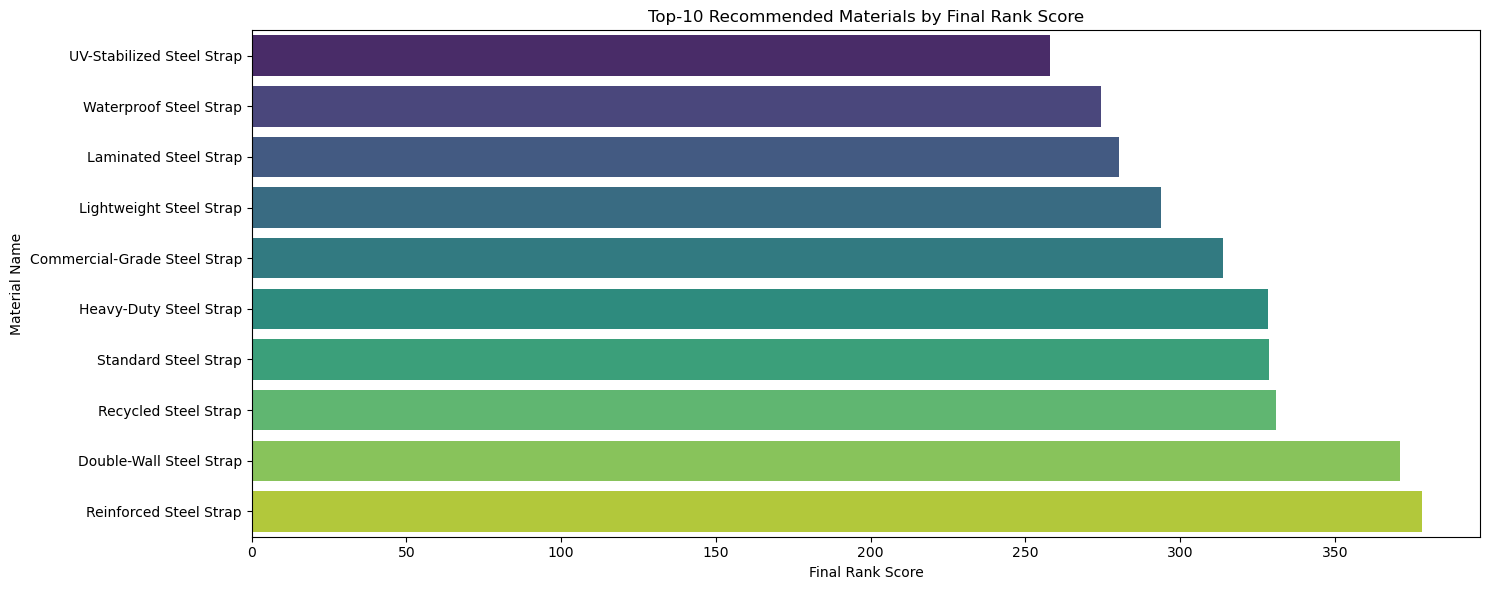

In [5]:
import matplotlib.ticker as mtick

# Bar chart: Top-10 by Final Rank Score
plt.figure(figsize=(15, 6))
sns.barplot(
    x='Final_Rank_Score', y='Material_Name',
    data=top10.sort_values('Final_Rank_Score', ascending=True),
    palette='viridis'
)
plt.title("Top-10 Recommended Materials by Final Rank Score")
plt.xlabel("Final Rank Score")
plt.ylabel("Material Name")
plt.tight_layout()
plt.show()

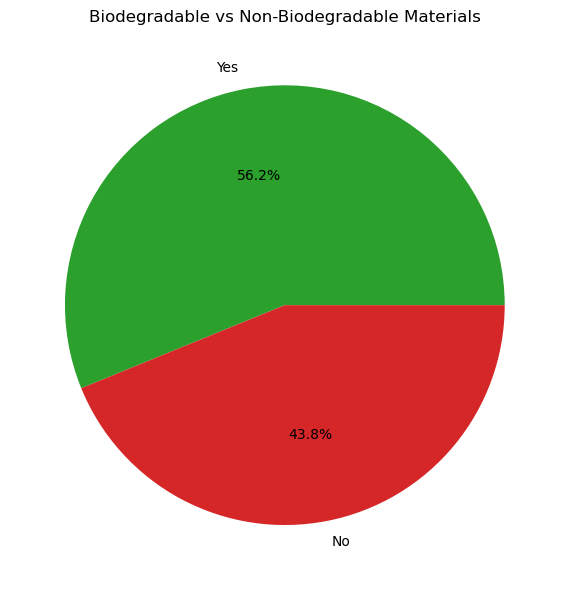

In [6]:
# Pie chart: Biodegradable distribution
plt.figure(figsize=(6, 6))
df['Biodegradable'].map({1: 'Yes', 0: 'No'}).value_counts().plot.pie(
    autopct='%1.1f%%', colors=['#2ca02c', '#d62728']
)
plt.title("Biodegradable vs Non-Biodegradable Materials")
plt.ylabel("")
plt.tight_layout()
plt.show()

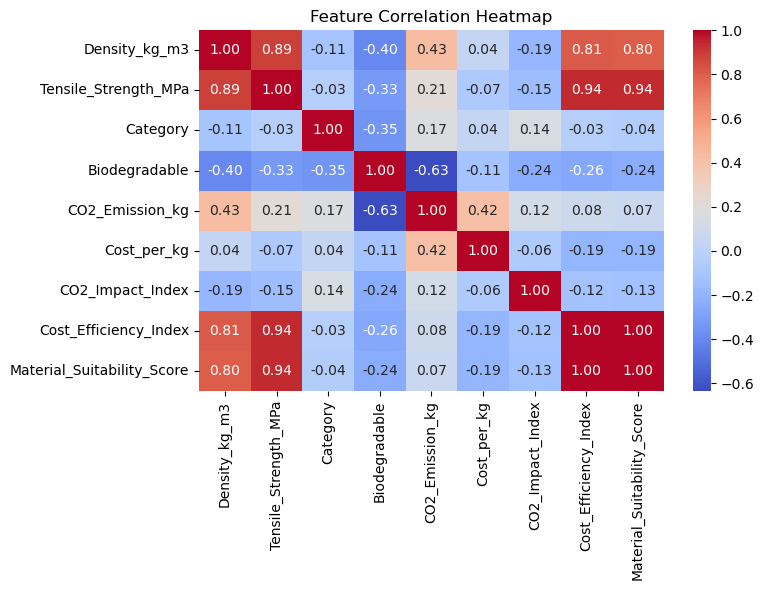

In [7]:
# Heatmap: Feature correlations
plt.figure(figsize=(8, 6))
corr = df[features + ['CO2_Emission_kg', 'Cost_per_kg',
                      'CO2_Impact_Index', 'Cost_Efficiency_Index',
                      'Material_Suitability_Score']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

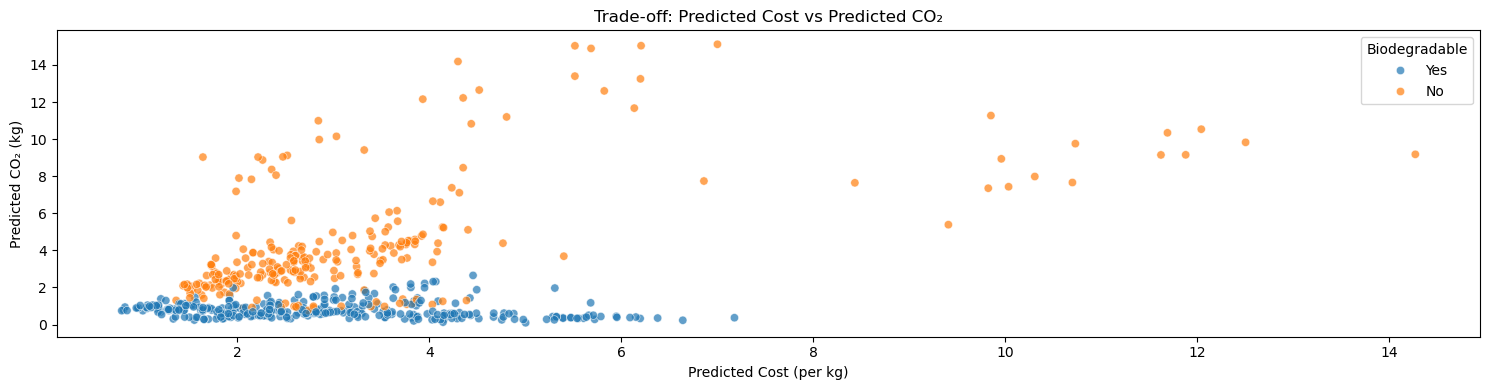

In [8]:
# Scatter: Predicted Cost vs Predicted CO2
plt.figure(figsize=(15, 4))
sns.scatterplot(
    x='Predicted_Cost', y='Predicted_CO2',
    hue=df['Biodegradable'].map({1: 'Yes', 0: 'No'}),
    data=df, alpha=0.7
)
plt.title("Trade-off: Predicted Cost vs Predicted CO₂")
plt.xlabel("Predicted Cost (per kg)")
plt.ylabel("Predicted CO₂ (kg)")
plt.legend(title="Biodegradable")
plt.tight_layout()
plt.show()

In [9]:
# # Save key artifacts
# results.to_csv("D:\\ecopackai\\model_evaluation_metrics.csv", index=False)
# top10.to_csv("D:\\ecopackai\\top10_recommendations.csv", index=False)

